### This notebook shows how to access/view training set stored in the database (zarr files)
Before running this notebook, please make sure you are using the correct init function in the second shell.

In [2]:
# must first specify the path of the data files
# if on SciServer, this step should be skipped
qso_path = '../data/qso.zarr.zip'
var_path = '../data/vstar.zarr.zip'

In [3]:
import pandas as pd
import numpy as np
import zarr
from utils import *
pd.set_option('display.max_columns', 999)

from matplotlib import pyplot as plt
%matplotlib inline

# # On SciSrver
# init()

# offline
init(qso_path, var_path)

### Note:
We start building the QSO catalog by selecting sources that are in the area of Stripe 82 from the SDSS DR7 Quasar catalog and the [DR14](https://www.sdss.org/dr14/algorithms/qso_catalog/) Quasar catalog seperatly, then find the union of these two samples to form the source catalog, which end up containing ~27k objects. Next, we query the Stripe 82 database on CAS to retrive the PSF magnitudes, errors and from [Stripe 82 DR7 Coadd](https://iopscience.iop.org/article/10.1088/0004-637X/794/2/120) and extinctions in all five bands. The exact query used is shown below:

```sql
select q.*, p.objid, p.psfmag_u, p.psfmag_g, p.psfmag_r, p.psfmag_i, p.psfmag_z,
  p.psfmagerr_u, p.psfmagerr_g, p.psfmagerr_r, p.psfmagerr_i, p.psfmagerr_z, p.extinction_u,
  p.extinction_g, p.extinction_r, p.extinction_i, p.extinction_z, b.distance
into mydb.qsoPhoto --ra, dec
from mydb.s82specqso as q
  cross apply fgetnearbyobjeq(q.ra, q.dec, 1/60.0) b
  join photoprimary as p on p.objid = b.objid
where ((p.flags & 0x10000000) != 0) 
  AND ((p.flags & 0x8100000c00a4) = 0) 
  AND (((p.flags & 0x400000000000) = 0) or (psfmagerr_g<=0.2))
  AND (((p.flags & 0x100000000000) = 0) or (p.flags & 0x1000) = 0)
  and (psfmagerr_g <= 1 and psfmagerr_r<= 1 and psfmagerr_i<=1 and psfmagerr_u<= 1 and psfmagerr_z<= 1)
  and (p.run = 106 or p.run = 206)
```

Lastly, we remove the objects don't have reliable detection in the Coadd. We are left with ~25k spectroscopically confirmed AGNs in the final catalog. Later, this catalog is matched to Gaia DR2 for proper motin and parallax measurments and SpIES for MIR detections.

**Missing data**   
All missing data the catalog is marked using `NaN`, except in the id columns (`gaia_id`, `SPIES_ID`, `thing_id`), where an integer '-99' is used. 

#### Check out qso master catalog

In [3]:
qso_df = get_qso_cat()
qso_df.head(3)

,train_id,ra_sdss,dec_sdss,sdssj,z,z_err,thing_id,specobjid,spec,objid,psfmag_u,psfmag_g,psfmag_r,psfmag_i,psfmag_z,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,spec2coadd,ra_sp,dec_sp,SPIES_ID,FLUX_AUTO_ch1,FLUXERR_AUTO_ch1,FLUX_AUTO_ch2,FLUXERR_AUTO_ch2,CLASS_STAR_ch1,CLASS_STAR_ch2,sdss2spies,sdss2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,lcN,psPm[0],psPm[1],psParallax,dered_u,dered_g,dered_r,dered_i,dered_z,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z]
0,0,310.0377,-1.005592,204009.04-010020.1,2.167268,0.000676,-99,276352159556042752,7,8647475119809364088,19.64425,19.11970,18.69050,18.39786,18.12030,0.008446,0.003265,0.003569,0.002969,0.005960,0.332155,0.244396,0.177257,0.134408,0.095297,0.083856,NaN,NaN,-99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024083,4226318531605913088,0.225240,0.283972,-0.609215,0.464463,-0.206735,0.305267,60,-0.609215,-0.206735,0.225240,19.312095,18.875304,18.513243,18.263452,18.025003,0.436791,0.362060,0.249792,0.238449,65942.328054,68419.255122,142798.907734,179737.984132,228014.565848
1,3,311.6088,0.393812,204626.10+002337.7,0.333015,0.000351,-99,537282917827608576,7,8647475121420632840,19.98406,18.87617,17.98685,17.88391,17.11791,0.011383,0.001996,0.001869,0.002298,0.003088,0.494767,0.364045,0.264036,0.200210,0.141952,0.051798,NaN,NaN,-99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092993,4228017414511443968,-0.149525,0.160723,0.044235,0.275073,0.075344,0.179892,69,0.044235,0.075344,-0.149525,19.489293,18.512125,17.722814,17.683700,16.975958,0.977168,0.789311,0.039115,0.707741,56011.332155,58115.957521,295732.889174,306580.434350,599285.639829
2,4,312.3636,0.718380,204927.25+004306.1,1.699121,0.000973,-99,314071864353751040,7,8647475121957832451,21.65874,20.98272,20.43363,19.93146,19.81973,0.037532,0.009041,0.007869,0.007637,0.022191,0.526905,0.387692,0.281186,0.213215,0.151172,0.154056,NaN,NaN,-99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218568,4228378535360381440,-0.486411,0.729782,-0.776679,2.051325,0.635052,1.033818,54,-0.776679,0.635052,-0.486411,21.131835,20.595028,20.152444,19.718245,19.668558,0.536807,0.442585,0.434199,0.049687,12319.895839,12794.084912,31547.575429,47059.204593,50039.124902


#### Show column definitions

In [4]:
qso_cat_meta()

{'CLASS_STAR_ch1': '3.6 micrometer morphology classification, > 0.5 for resolved source',
 'CLASS_STAR_ch2': '4.5 micrometer morphology classification, > 0.5 for resolved source',
 'FLUXERR_AUTO_ch1': '3.6 micrometer flux error given by SExtractor',
 'FLUXERR_AUTO_ch2': '4.5 micrometer flux error given by SExtractor',
 'FLUX_AUTO_ch1': '3.6 micrometer flux value automatically extracted using SExtractor',
 'FLUX_AUTO_ch2': '4.5 micrometer flux value automatically extracted using SExtractor',
 'SPIES_ID': 'Unique ID assigned to each source in SpIES if match exists, otherwise -99',
 'dec_sdss': 'DEC from SDSS in degrees (J2000 degree)',
 'dec_sp': 'DEC from SpIES in degrees (J2000)',
 'dered_{band}': 'SDSS mag corrected for extinction',
 'extinction_{band}': 'Extinction in u,g,r,i,z',
 'gaia_id': 'Gaia DR2 source id if match exists, otherwise -99',
 'lcN': 'Number of data points in the corresponding light curve',
 'objid': 'DR7 coadd photo object id',
 'parallax': 'Gaia DR2 parallax in ma

#### P.S.
We added a few more columns to best mimc the LSST data models, specifically **psPm[]**, **psParallax**, **psFlux[]** and **stdColor[]**. Detailed column definition can be obtain using function ``qso_cat_meta()``

#### Get/Plot light curves

The light curves are also retrived from SDSS CAS using the following query:

```sql
select q.train_id, p.run, p.psfmag_u, p.psfmag_g, p.psfmag_r, p.psfmag_i, p.psfmag_z,
  p.psfmagerr_u, p.psfmagerr_g, p.psfmagerr_r, p.psfmagerr_i, p.psfmagerr_z, p.offsetRa_u, 
  p.offsetRa_g, p.offsetRa_i, p.offsetRa_z, p.offsetDec_u, p.offsetDec_g, p.offsetDec_i, 
  p.offsetDec_z, f.airmass_u, f.airmass_g, f.airmass_r, f.airmass_i, f.airmass_z, 
  LTRIM(STR(mjd_u,20,2)) as mjd_u,
  LTRIM(STR(mjd_g,20,2)) as mjd_g,
  LTRIM(STR(mjd_r,20,2)) as mjd_r,
  LTRIM(STR(mjd_i,20,2)) as mjd_i,
  LTRIM(STR(mjd_z,20,2)) as mjd_z
into mydb.s82qsoLC
from mydb.s82qsoFinal as q -- ra, dec
  cross apply fgetnearbyobjalleq(q.ra, q.dec, 1/60.0) b
  join photoobj as p on p.objid = b.objid --photoobj for both primary+secondary
  join field as f on f.fieldid = p.fieldid
where ((p.flags & 0x10000000) != 0) 
  AND ((p.flags & 0x8100000c00a4) = 0) 
  AND (((p.flags & 0x400000000000) = 0) or (p.psfmagerr_r <= 0.2))
  AND (((p.flags & 0x100000000000) = 0) or (p.flags & 0x1000) = 0)
  and (p.psfmagerr_g <= 1 and p.psfmagerr_r<= 1 and p.psfmagerr_i<=1 and p.psfmagerr_u<= 1 and p.psfmagerr_z<= 1)
  and (p.run !=106)
  and (p.run !=206)
  and f.quality in (2,3)
order by train_id
```

- To retrieve the light curve for any object, use functions ``get_sdss_qso()`` while providing `ID_sdss` as the only input.    
- To plot the light curves, use functions `plot_sdss_qso()` for original data, or use functions `plot_merge_gri()` for merged light curves normalized by mean or median of each band. 

To see what arguments can be passed to each function, use the help method, `help(plot_sdss_qso)` for example.  

In [5]:
help(plot_sdss_qso)

Help on function plot_sdss_qso in module utils:

plot_sdss_qso(train_id, bands=['u', 'g', 'r', 'i', 'z'], clip=True)
    Plot SDSS quasar light curves without merging.
    
    Args:
        train_id (int): Unique ID for an object in training sample.
        bands (list): A list specifying light curves in which bands to plot.
        clip (bool): Indicates whether to run filter removing outliers.



**Currently, we only normalize and merge light curve by subtracting the mean or median (can be specified while calling the plot function). Certainly, more sphoiscated light curve merging methods should be implemented, for example, [CREAM](https://academic.oup.com/mnras/article/456/2/1960/1066664), but computing cost should also be considered. For now, this should be okay to get started. Any comments/suggestions for better light curve merging methods are welcome.**

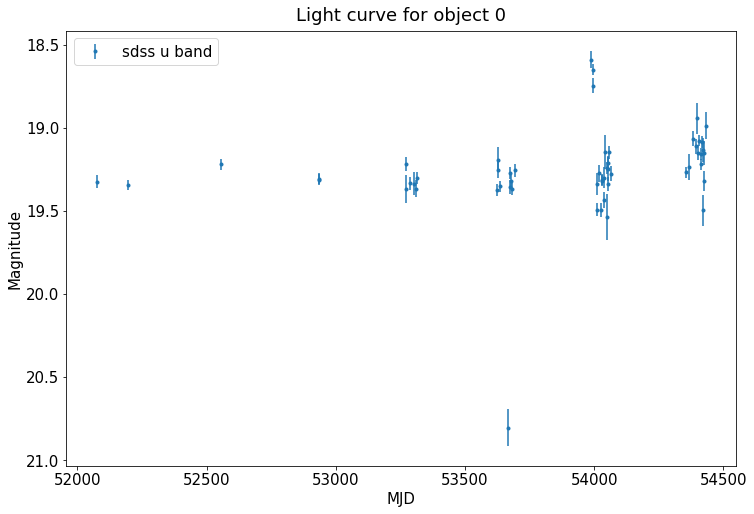

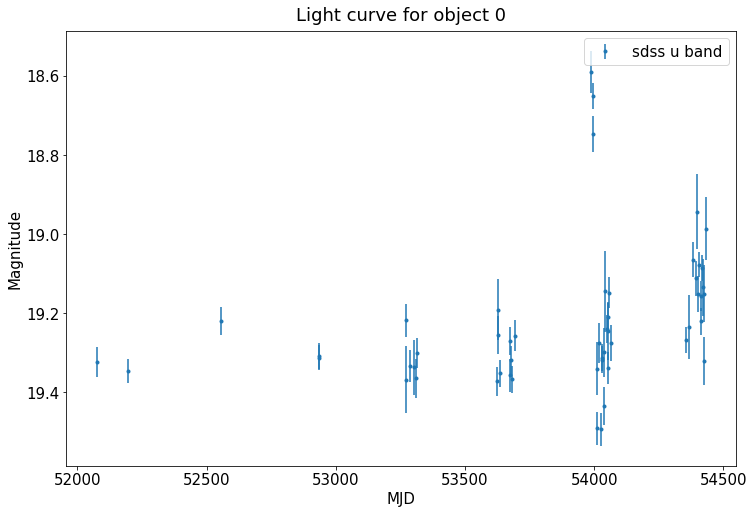

In [6]:
# plot all data
plot_sdss_qso(0, clip=False, bands=['u']) # original
plot_sdss_qso(0, bands=['u']) # clean

**Note:**  
From the first plot above, we can see the flux suddenly drop around MJD=53650. We suspect that is caused some kind of calibration failures, since such behavior is observed across many light curves and all occured around that time. Further clean up is needed for a better use of the light curves. So we implemented the feature to remove artifacts by first apply a three point median filter to the light curve, and remove outliers that deviate more than 5-sigma from the median filtered light curve. The filtered light curve is shown in the second plot.

In [7]:
# an invalid id will raise an Exception
plot_sdss_qso(1)

Exception: train_id provided is not valid!

A list of valid `train_id`s can found from the master catalog or use the function `valid_ids()`. The returned is a pandas dataframe containing all valid `train_id`s for AGNs and non-AGN variables.

In [8]:
valid_ids().head(2)

,train_id,Type
0,0,AGN
1,3,AGN


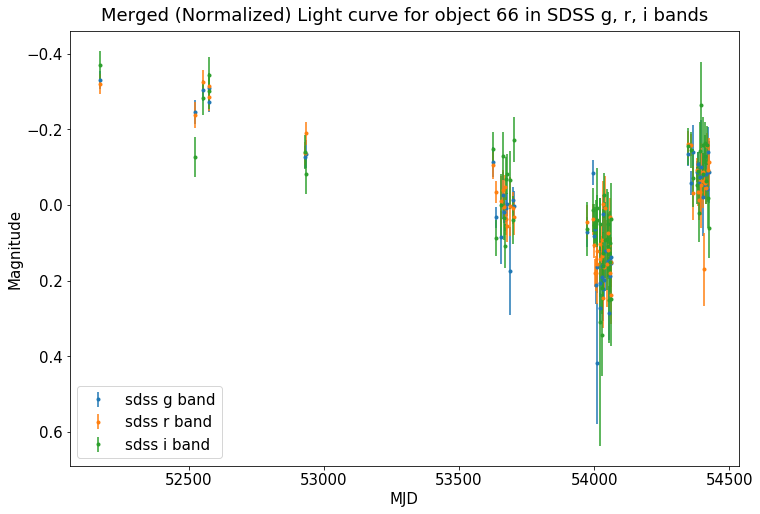

In [9]:
# merged lc using sdss g, r, i
plot_merge_gri(66)

---
## Non-AGN variables

### Note:
The non-AGN variables catalog consists of all objects in [Ivezic et al. 2007](http://faculty.washington.edu/ivezic/sdss/catalogs/S82variables.html) except those have been identified as AGN using spectrum. Thus we are **NOT** confident that all sources in this catalog are non-AGN. This catalog could contains AGNs that were missed by target selection algorithms at the first place.  All SDSS light curves all also queried directly from CAS using the following query:

```sql
select q.train_d, q.ivz_id, p.run, p.psfmag_u, p.psfmag_g, p.psfmag_r, p.psfmag_i, p.psfmag_z,
  p.psfmagerr_u, p.psfmagerr_g, p.psfmagerr_r, p.psfmagerr_i, p.psfmagerr_z, p.offsetRa_u, 
  p.offsetRa_g, p.offsetRa_i, p.offsetRa_z, p.offsetDec_u, p.offsetDec_g, p.offsetDec_i, 
  p.offsetDec_z, f.airmass_u, f.airmass_g, f.airmass_r, f.airmass_i, f.airmass_z, 
  LTRIM(STR(mjd_u,20,2)) as mjd_u,
  LTRIM(STR(mjd_g,20,2)) as mjd_g,
  LTRIM(STR(mjd_r,20,2)) as mjd_r,
  LTRIM(STR(mjd_i,20,2)) as mjd_i,
  LTRIM(STR(mjd_z,20,2)) as mjd_z
into mydb.vstarLC
from mydb.vstarFinal as q --catalog including ra, dec
  cross apply fgetnearbyobjalleq(q.ra, q.dec, 1/60.0) b
  -- join photoobj below to get both primary+secondary object
  join photoobj as p on p.objid = b.objid
  join field as f on f.fieldid = p.fieldid
where ((p.flags & 0x10000000) != 0) 
  AND ((p.flags & 0x8100000c00a4) = 0) 
  AND (((p.flags & 0x400000000000) = 0) or (p.psfmagerr_r <= 0.2))
  AND (((p.flags & 0x100000000000) = 0) or (p.flags & 0x1000) = 0)
  and (p.psfmagerr_g <= 1 and p.psfmagerr_r<= 1 and p.psfmagerr_i<=1 and p.psfmagerr_u<= 1 and p.psfmagerr_z<= 1)
  and (p.run !=106)
  and (p.run !=206)
  and f.quality in (2,3)
  and p.type = 6
order by train_d
```

#### Check out master catalog

In [10]:
vstar_df = get_var_cat()
vstar_df.head(2)

,train_id,ivz_id,ra_sdss,dec_sdss,sdss2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_sp,dec_sp,SPIES_ID,FLUX_AUTO_ch1,FLUXERR_AUTO_ch1,FLUX_AUTO_ch2,FLUXERR_AUTO_ch2,CLASS_STAR_ch1,CLASS_STAR_ch2,sdss2spies,objid,psfmag_u,psfmag_g,psfmag_r,psfmag_i,psfmag_z,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,lcN,psPm[0],psPm[1],psParallax,dered_u,dered_g,dered_r,dered_i,dered_z,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z]
0,100070,74,2.714809,0.963019,0.098278,2546353103253723136,-0.330858,1.105588,0.161619,1.966663,-6.564630,0.950373,NaN,NaN,-99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8658188596295368704,20.79964,20.04293,19.78893,19.69865,19.61046,0.074844,0.030475,0.038231,0.049764,0.074923,0.123449,0.090832,0.065879,0.049954,0.035418,38,0.161619,-6.564630,-0.330858,20.676191,19.952098,19.723051,19.648696,19.575042,0.724094,0.229047,0.074355,0.073654,18760.905302,19472.756319,46856.340525,50173.482427,54565.860523
1,100073,429,1.145510,-0.887604,0.089019,2545683333166174720,0.982614,0.271784,13.324682,0.567646,-16.236439,0.230887,NaN,NaN,-99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8658170687895109632,21.70556,19.35863,18.00129,17.24292,16.78838,0.161327,0.051916,0.034715,0.013419,0.025616,0.185682,0.136623,0.099091,0.075137,0.053273,14,13.324682,-16.236439,0.982614,21.519878,19.222007,17.902199,17.167783,16.735107,2.297871,1.319807,0.734417,0.432676,8603.466401,8943.271578,250694.695652,493074.367005,748131.196335


#### Show column definitions

In [11]:
var_cat_meta()

{'CLASS_STAR_ch1': '3.6 micrometer morphology classification, > 0.5 for resolved source',
 'CLASS_STAR_ch2': '4.5 micrometer morphology classification, > 0.5 for resolved source',
 'FLUXERR_AUTO_ch1': '3.6 micrometer flux error given by SExtractor',
 'FLUXERR_AUTO_ch2': '4.5 micrometer flux error given by SExtractor',
 'FLUX_AUTO_ch1': '3.6 micrometer flux value automatically extracted using SExtractor',
 'FLUX_AUTO_ch2': '4.5 micrometer flux value automatically extracted using SExtractor',
 'SPIES_ID': 'Unique ID assigned to each source in SpIES if match exists, otherwise -99',
 'dec': 'DEC from SDSS in degrees (J2000 degree)',
 'dec_sp': 'DEC from SpIES in degrees (J2000)',
 'dered_{band}': 'SDSS mag corrected for extinction',
 'extinction_{band}': 'Extinction in u,g,r,i,z',
 'gaia_id': 'Gaia DR2 source id if match exists, otherwise -99',
 'ivz_id': 'Unique ID for each non-AGN variable source in the training set.',
 'lcN': 'Number of data points in the corresponding light curve',
 'o

#### P.S.
We added a few more columns to best mimc the LSST data models, specifically **psPm[]**, **psParallax**, **psFlux[]** and **stdColor[]**. Detailed column definition can be obtain using function ``var_cat_meta()``

#### Get/Plot light curves
- To retrieve the light curves, use function `get_sdss_var()` with `train_id` at the input.  
- To plot the light curves, use function `plot_var()` or `plot_merge_gri()`.

The `train_id` for non-AGN variable start at 100070. As for the QSO light curves, `clip` is set to `True` as the default.

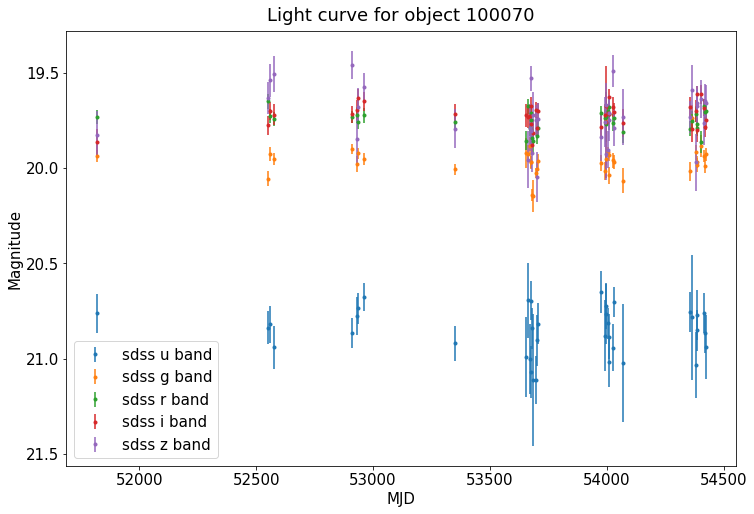

In [12]:
# plot var
plot_var(100070)

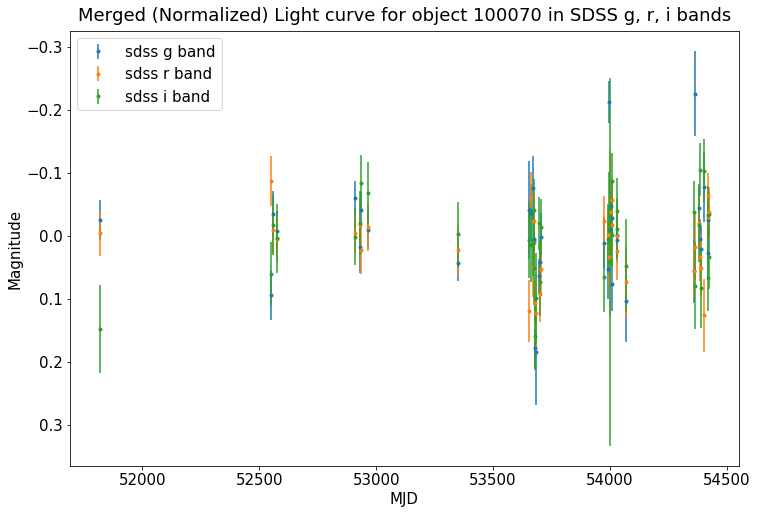

In [13]:
# plot gri merged light curve
plot_merge_gri(100070)

#### Directly retriving light curves
Lastly, you can directly retrieve the light curve and make your own plots. To get the light curves, you can use function `get_sdss_qso()` for QSOs and `get_sdss_var` for non-AGN variables. Both functions return light curves in pandas dataframes.

In [5]:
var_lc = get_sdss_var(100070)
var_lc.head(5)

,run,psfmag_u,psfmag_g,psfmag_r,psfmag_i,psfmag_z,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,mjd_u,mjd_g,mjd_r,mjd_i,mjd_z,offsetRa_u,offsetRa_g,offsetRa_i,offsetRa_z,offsetDec_u,offsetDec_g,offsetDec_i,offsetDec_z,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,dered_u,dered_g,dered_r,dered_i,dered_z,datetime_u,datetime_g,datetime_r,datetime_i,datetime_z
0,1755,20.885523,20.027636,19.798820,19.914682,19.860619,0.101830,0.031450,0.035450,0.069354,0.124262,51819.36,51819.36,51819.36,51819.36,51819.36,0.002408,0.008112,-0.112632,0.088739,-0.288459,0.005584,-0.021420,-0.218556,1.400717,1.410242,1.391463,1.396059,1.405441,20.762074,19.936804,19.732941,19.864728,19.825201,2000-10-02 08:38:24,2000-10-02 08:38:24,2000-10-02 08:38:24,2000-10-02 08:38:24,2000-10-02 08:38:24
1,3360,20.959929,20.146847,19.715406,19.826345,19.666573,0.087285,0.038906,0.039449,0.050292,0.084846,52552.32,52552.32,52552.32,52552.32,52552.32,0.020006,-0.029200,0.065273,0.025147,-0.013126,0.006061,-0.015601,-0.032119,1.250471,1.255237,1.245871,1.248151,1.252832,20.836480,20.056015,19.649527,19.776391,19.631155,2002-10-05 07:40:48,2002-10-05 07:40:48,2002-10-05 07:40:48,2002-10-05 07:40:48,2002-10-05 07:40:48
2,3388,20.942463,20.017487,19.793941,19.749779,19.574190,0.095892,0.035451,0.036882,0.047899,0.086905,52558.33,52558.33,52558.33,52558.33,52558.33,0.146601,0.111905,0.072093,0.197701,-0.018517,-0.016184,0.002213,-0.085853,1.341357,1.349099,1.333843,1.337577,1.345198,20.819014,19.926655,19.728062,19.699825,19.538772,2002-10-11 07:55:12,2002-10-11 07:55:12,2002-10-11 07:55:12,2002-10-11 07:55:12,2002-10-11 07:55:12
3,3434,21.062973,20.045113,19.807596,19.770746,19.542093,0.113029,0.032065,0.036984,0.054642,0.095499,52577.22,52577.22,52577.21,52577.21,52577.22,0.028844,-0.009625,0.000479,0.093240,-0.057429,-0.041183,-0.043305,0.038111,1.185194,1.186768,1.183748,1.184456,1.185964,20.939524,19.954281,19.741717,19.720792,19.506675,2002-10-30 05:16:48,2002-10-30 05:16:48,2002-10-30 05:02:24,2002-10-30 05:02:24,2002-10-30 05:16:48
4,4145,20.988451,19.992407,19.797653,19.767600,19.494757,0.080537,0.026328,0.032871,0.044949,0.075043,52910.30,52910.30,52910.30,52910.30,52910.30,-0.014744,-0.023143,-0.010900,0.003784,0.018715,0.008121,0.006175,-0.113244,1.181776,1.183026,1.180650,1.181198,1.182385,20.865002,19.901575,19.731774,19.717646,19.459339,2003-09-28 07:12:00,2003-09-28 07:12:00,2003-09-28 07:12:00,2003-09-28 07:12:00,2003-09-28 07:12:00
